# DataFrame Library Comparison: Polars vs Pandas vs Dask

**Real-world performance test on event extraction from market data**

This notebook compares three popular DataFrame libraries on a real data engineering task:
extracting trading events from market order snapshots.

## The Task

Event extraction requires:
1. **Reading Parquet files** (I/O performance)
2. **Filtering data** by conditions
3. **Joining snapshots** on order_id
4. **Detecting changes** (disappeared orders, volume changes, new orders)

## The Libraries

- **Polars**: Modern, multi-threaded, built on Apache Arrow
- **Pandas**: Classic, single-threaded, most widely used
- **Dask**: Parallel/distributed computing, pandas-compatible API

Let's see which one performs best!

---

## Configuration

In [11]:
# ============================================================
# CONFIGURATION
# ============================================================

from pathlib import Path

# Data location
EVE_DATA_PATH = Path("/Users/fred/Projects/Gaming/Eve Online/eve_market_data/data/orders")

# How many snapshot pairs to test (more = longer test, more accurate)
NUM_SNAPSHOT_PAIRS = 11  # Use 3 for quick test, 11 for full hour

# Backends to test
BACKENDS = ['polars', 'pandas', 'dask']

print("📋 Configuration:")
print(f"   Data path: {EVE_DATA_PATH}")
print(f"   Testing {NUM_SNAPSHOT_PAIRS} snapshot pairs")
print(f"   Backends: {', '.join(BACKENDS)}")

📋 Configuration:
   Data path: /Users/fred/Projects/Gaming/Eve Online/eve_market_data/data/orders
   Testing 11 snapshot pairs
   Backends: polars, pandas, dask


## Setup

Import libraries and load snapshot files.

In [12]:
import sys
import time
from datetime import datetime
import polars as pl
import pandas as pd
import dask.dataframe as dd

print("✅ Imports successful")

✅ Imports successful


In [13]:
# Find snapshot files
snapshot_files = sorted(EVE_DATA_PATH.glob("region_10000002_2025-10-22T07-*.parquet"))
snapshot_files += sorted(EVE_DATA_PATH.glob("region_10000002_2025-10-22T08-*.parquet"))[:3]
snapshot_files = snapshot_files[:12]

print(f"📂 Found {len(snapshot_files)} snapshot files")
print(f"\n⏱️  Time range:")
print(f"   Start: {snapshot_files[0].name}")
print(f"   End:   {snapshot_files[-1].name}")

# Create snapshot pairs for testing
snapshot_pairs = [
    (snapshot_files[i], snapshot_files[i+1]) 
    for i in range(min(NUM_SNAPSHOT_PAIRS, len(snapshot_files)-1))
]

print(f"\n🔍 Will test with {len(snapshot_pairs)} snapshot pairs")

📂 Found 12 snapshot files

⏱️  Time range:
   Start: region_10000002_2025-10-22T07-00-00+00-00.parquet
   End:   region_10000002_2025-10-22T07-55-00+00-00.parquet

🔍 Will test with 11 snapshot pairs


---

## Performance Test: Real Event Extraction with Initialization

We'll run the exact same event detection logic with three different DataFrame backends.

### Complete Event Extraction Process:

**Step 1: Initialization** (create baseline state)
- Read first snapshot (snapshot "0")
- Generate ORDER_OPENED events for all existing orders
- This establishes the baseline state, making the event log self-contained

**Step 2: Delta Event Detection** (process subsequent snapshots)
1. Read two consecutive snapshots (Parquet files)
2. Identify disappeared orders (→ TRADE or CANCELLED events)
3. Detect volume reductions (→ TRADE events)
4. Find new orders (→ ORDER_OPENED events)
5. Spot price changes (→ PRICE_CHANGED events)

This is a real-world workload combining I/O, joins, filters, and transformations.

**Why initialization matters**: With the baseline events from snapshot "0", we can reconstruct the complete order book state at any timestamp using only the event log - no anchor snapshots needed!

In [14]:
print(f"🔍 Comparing OPTIMIZED event extraction performance")
print(f"   Testing with {len(snapshot_pairs)} snapshot pairs\n")
print("="*70)

# Import optimized detectors
from src.event_extractor.event_detector_polars import PolarsEventDetector
from src.event_extractor.event_detector_pandas import PandasEventDetector
from src.event_extractor.event_detector_dask import DaskEventDetector

results = {}

# Test 1: POLARS (optimized - vectorized operations)
print("\n📊 POLARS (vectorized, multi-threaded)")
detector_polars = PolarsEventDetector()

start = time.time()

# Step 1: Initialize from first snapshot (baseline state)
timestamp_0 = datetime.strptime(snapshot_files[0].stem.split('_')[-1].replace('+00-00', ''), "%Y-%m-%dT%H-%M-%S")
init_events = detector_polars.initialize_from_snapshot(snapshot_files[0], timestamp_0)
total_events = len(init_events)

# Step 2: Process delta events from snapshot pairs
for prev_file, curr_file in snapshot_pairs:
    timestamp_str = curr_file.stem.split('_')[-1].replace('+00-00', '')
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H-%M-%S")
    events = detector_polars.detect_events(prev_file, curr_file, timestamp)
    total_events += len(events)

elapsed = time.time() - start
results['polars'] = {
    'time': elapsed,
    'events': total_events,
    'init_events': len(init_events),
    'delta_events': total_events - len(init_events),
    'avg_per_interval': elapsed / len(snapshot_pairs)
}

print(f"   Time: {elapsed:.3f} seconds")
print(f"   Events: {total_events:,} ({len(init_events):,} init + {total_events - len(init_events):,} delta)")
print(f"   Avg per interval: {elapsed/len(snapshot_pairs):.3f}s")

# Test 2: PANDAS (optimized - vectorized groupby, itertuples)
print("\n📊 PANDAS (vectorized where possible, single-threaded)")
detector_pandas = PandasEventDetector()

start = time.time()

# Step 1: Initialize from first snapshot
init_events = detector_pandas.initialize_from_snapshot(snapshot_files[0], timestamp_0)
total_events = len(init_events)

# Step 2: Process delta events
for prev_file, curr_file in snapshot_pairs:
    timestamp_str = curr_file.stem.split('_')[-1].replace('+00-00', '')
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H-%M-%S")
    events = detector_pandas.detect_events(prev_file, curr_file, timestamp)
    total_events += len(events)

elapsed = time.time() - start
results['pandas'] = {
    'time': elapsed,
    'events': total_events,
    'init_events': len(init_events),
    'delta_events': total_events - len(init_events),
    'avg_per_interval': elapsed / len(snapshot_pairs)
}

print(f"   Time: {elapsed:.3f} seconds")
print(f"   Events: {total_events:,} ({len(init_events):,} init + {total_events - len(init_events):,} delta)")
print(f"   Avg per interval: {elapsed/len(snapshot_pairs):.3f}s")

# Test 3: DASK (batch processing - TRUE parallelism)
print("\n📊 DASK (parallel batch processing across CPU cores)")
detector_dask = DaskEventDetector(n_workers=4)

start = time.time()

# Step 1: Initialize from first snapshot
init_events = detector_dask.initialize_from_snapshot(snapshot_files[0], timestamp_0)

# Step 2: Prepare batch data for parallel processing
batch_pairs = [
    (prev, curr, datetime.strptime(curr.stem.split('_')[-1].replace('+00-00', ''), "%Y-%m-%dT%H-%M-%S"))
    for prev, curr in snapshot_pairs
]

# Process all pairs in parallel
delta_events = detector_dask.detect_events_batch(batch_pairs)

elapsed = time.time() - start
total_events = len(init_events) + len(delta_events)

results['dask'] = {
    'time': elapsed,
    'events': total_events,
    'init_events': len(init_events),
    'delta_events': len(delta_events),
    'avg_per_interval': elapsed / len(snapshot_pairs)
}

print(f"   Time: {elapsed:.3f} seconds")
print(f"   Events: {total_events:,} ({len(init_events):,} init + {len(delta_events):,} delta)")
print(f"   Avg per interval: {elapsed/len(snapshot_pairs):.3f}s")
print(f"   (Processing {len(snapshot_pairs)} pairs in parallel!)")

print("\n" + "="*70)

🔍 Comparing OPTIMIZED event extraction performance
   Testing with 11 snapshot pairs


📊 POLARS (vectorized, multi-threaded)
🌱 Initializing event log from snapshot: 375,338 orders
   Time: 1.792 seconds
   Events: 388,513 (375,338 init + 13,175 delta)
   Avg per interval: 0.163s

📊 PANDAS (vectorized where possible, single-threaded)
🌱 Initializing event log from snapshot: 375,338 orders
   Time: 5.007 seconds
   Events: 388,513 (375,338 init + 13,175 delta)
   Avg per interval: 0.455s

📊 DASK (parallel batch processing across CPU cores)
🌱 Initializing event log from snapshot: 375,338 orders
   Time: 2.653 seconds
   Events: 388,513 (375,338 init + 13,175 delta)
   Avg per interval: 0.241s
   (Processing 11 pairs in parallel!)



---

## Results Analysis

In [15]:
# Sort backends by performance (fastest to slowest)
sorted_backends = sorted(BACKENDS, key=lambda b: results[b]['time'])
winner = sorted_backends[0]
pandas_time = results['pandas']['time']
winner_time = results[winner]['time']

print("\n⚡ SPEEDUP COMPARISON (vs Pandas):")
print("="*70)

for backend in sorted_backends:
    if backend != 'pandas':
        speedup = pandas_time / results[backend]['time']
        print(f"   {backend.capitalize():8} {speedup:5.2f}× faster than Pandas")
    else:
        print(f"   {backend.capitalize():8} baseline")

print("\n" + "="*70)

# Show detailed breakdown - ordered by performance
print("\n📊 DETAILED BREAKDOWN (fastest → slowest):")
print("="*70)
print(f"{'Rank':<6} {'Backend':<10} {'Total Time':>12} {'Avg/Interval':>15} {'Events':>10}")
print("-"*70)

for rank, backend in enumerate(sorted_backends, 1):
    r = results[backend]
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{medal} {rank}. {backend.capitalize():<10} {r['time']:>10.3f}s {r['avg_per_interval']:>13.3f}s {r['events']:>10,}")

print("="*70)


⚡ SPEEDUP COMPARISON (vs Pandas):
   Polars    2.79× faster than Pandas
   Dask      1.89× faster than Pandas
   Pandas   baseline


📊 DETAILED BREAKDOWN (fastest → slowest):
Rank   Backend      Total Time    Avg/Interval     Events
----------------------------------------------------------------------
🥇 1. Polars          1.792s         0.163s    388,513
🥈 2. Dask            2.653s         0.241s    388,513
🥉 3. Pandas          5.007s         0.455s    388,513


In [16]:
import pandas as pd

# Storage for detailed timing results
detailed_results = {}

print("🔬 DETAILED TIMING BREAKDOWN")
print("="*80)

# ============================================================================
# POLARS - Detailed Timing
# ============================================================================
print("\n📊 POLARS")

# Phase 1: Setup
start = time.time()
detector = PolarsEventDetector()
setup_time = time.time() - start

# Phase 2: Initialization
start = time.time()
init_events = detector.initialize_from_snapshot(snapshot_files[0], timestamp_0)
init_time = time.time() - start

# Phase 3: Delta Processing
start = time.time()
total_delta_events = 0
for prev_file, curr_file in snapshot_pairs:
    timestamp_str = curr_file.stem.split('_')[-1].replace('+00-00', '')
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H-%M-%S")
    events = detector.detect_events(prev_file, curr_file, timestamp)
    total_delta_events += len(events)
delta_time = time.time() - start

total_time = setup_time + init_time + delta_time
detailed_results['polars'] = {
    'setup': setup_time,
    'initialization': init_time,
    'delta_processing': delta_time,
    'total': total_time,
    'init_events': len(init_events),
    'delta_events': total_delta_events
}

print(f"   Setup:            {setup_time*1000:8.2f} ms")
print(f"   Initialization:   {init_time:8.3f} s  ({len(init_events):,} events)")
print(f"   Delta Processing: {delta_time:8.3f} s  ({total_delta_events:,} events)")
print(f"   ─────────────────────────────")
print(f"   Total:            {total_time:8.3f} s")

# ============================================================================
# PANDAS - Detailed Timing
# ============================================================================
print("\n📊 PANDAS")

# Phase 1: Setup
start = time.time()
detector = PandasEventDetector()
setup_time = time.time() - start

# Phase 2: Initialization
start = time.time()
init_events = detector.initialize_from_snapshot(snapshot_files[0], timestamp_0)
init_time = time.time() - start

# Phase 3: Delta Processing
start = time.time()
total_delta_events = 0
for prev_file, curr_file in snapshot_pairs:
    timestamp_str = curr_file.stem.split('_')[-1].replace('+00-00', '')
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%dT%H-%M-%S")
    events = detector.detect_events(prev_file, curr_file, timestamp)
    total_delta_events += len(events)
delta_time = time.time() - start

total_time = setup_time + init_time + delta_time
detailed_results['pandas'] = {
    'setup': setup_time,
    'initialization': init_time,
    'delta_processing': delta_time,
    'total': total_time,
    'init_events': len(init_events),
    'delta_events': total_delta_events
}

print(f"   Setup:            {setup_time*1000:8.2f} ms")
print(f"   Initialization:   {init_time:8.3f} s  ({len(init_events):,} events)")
print(f"   Delta Processing: {delta_time:8.3f} s  ({total_delta_events:,} events)")
print(f"   ─────────────────────────────")
print(f"   Total:            {total_time:8.3f} s")

# ============================================================================
# DASK - Detailed Timing
# ============================================================================
print("\n📊 DASK")

# Phase 1: Setup
start = time.time()
detector = DaskEventDetector(n_workers=4)
setup_time = time.time() - start

# Phase 2: Initialization
start = time.time()
init_events = detector.initialize_from_snapshot(snapshot_files[0], timestamp_0)
init_time = time.time() - start

# Phase 3: Delta Processing (batch)
start = time.time()
delta_events = detector.detect_events_batch(batch_pairs)
delta_time = time.time() - start

total_time = setup_time + init_time + delta_time
detailed_results['dask'] = {
    'setup': setup_time,
    'initialization': init_time,
    'delta_processing': delta_time,
    'total': total_time,
    'init_events': len(init_events),
    'delta_events': len(delta_events)
}

print(f"   Setup:            {setup_time*1000:8.2f} ms")
print(f"   Initialization:   {init_time:8.3f} s  ({len(init_events):,} events)")
print(f"   Delta Processing: {delta_time:8.3f} s  ({len(delta_events):,} events, parallel)")
print(f"   ─────────────────────────────")
print(f"   Total:            {total_time:8.3f} s")

print("\n" + "="*80)

🔬 DETAILED TIMING BREAKDOWN

📊 POLARS
🌱 Initializing event log from snapshot: 375,338 orders
   Setup:                0.03 ms
   Initialization:      1.402 s  (375,338 events)
   Delta Processing:    0.553 s  (13,175 events)
   ─────────────────────────────
   Total:               1.955 s

📊 PANDAS
🌱 Initializing event log from snapshot: 375,338 orders
   Setup:                0.02 ms
   Initialization:      1.463 s  (375,338 events)
   Delta Processing:    3.320 s  (13,175 events)
   ─────────────────────────────
   Total:               4.783 s

📊 DASK
🌱 Initializing event log from snapshot: 375,338 orders
   Setup:                0.03 ms
   Initialization:      1.952 s  (375,338 events)
   Delta Processing:    0.995 s  (13,175 events, parallel)
   ─────────────────────────────
   Total:               2.947 s



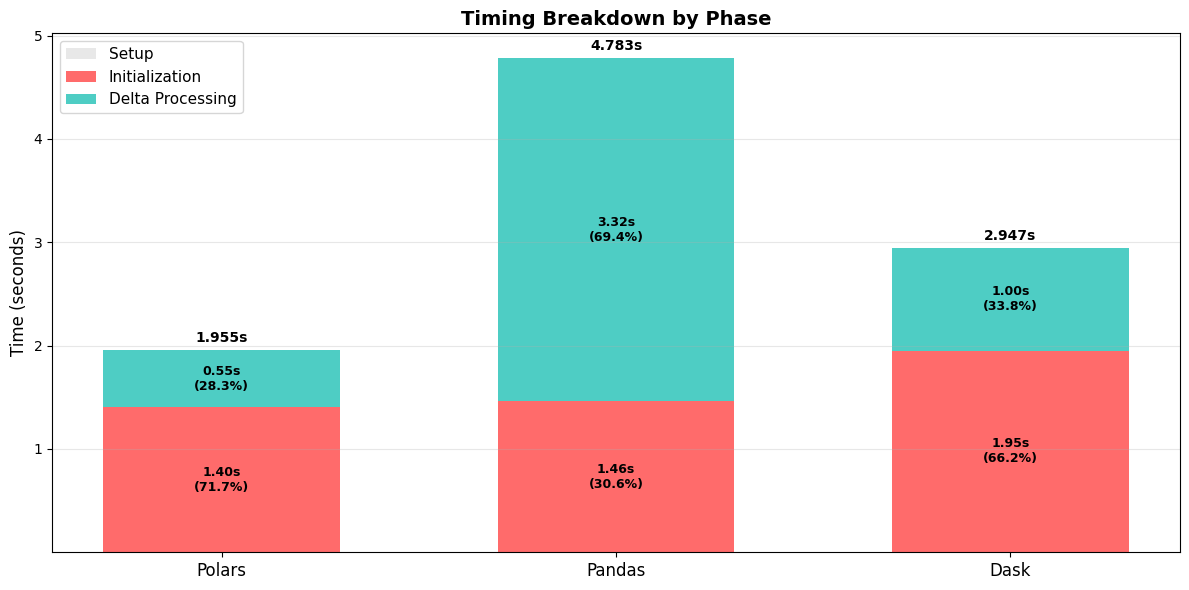


💡 KEY INSIGHTS:

Polars:
   Initialization:  71.7% of total time
   Delta Processing:  28.3% of total time

Pandas:
   Initialization:  30.6% of total time
   Delta Processing:  69.4% of total time

Dask:
   Initialization:  66.2% of total time
   Delta Processing:  33.8% of total time
   → Dask's parallelism only affects 33.8% of the workload!
   → 66.2% is single-threaded initialization


In [17]:
# Create a visual comparison of timing breakdown
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for stacked bar chart
backends = ['Polars', 'Pandas', 'Dask']
setup_times = [detailed_results['polars']['setup'], 
               detailed_results['pandas']['setup'], 
               detailed_results['dask']['setup']]
init_times = [detailed_results['polars']['initialization'], 
              detailed_results['pandas']['initialization'], 
              detailed_results['dask']['initialization']]
delta_times = [detailed_results['polars']['delta_processing'], 
               detailed_results['pandas']['delta_processing'], 
               detailed_results['dask']['delta_processing']]

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(backends))
width = 0.6

p1 = ax.bar(x, setup_times, width, label='Setup', color='#E8E8E8')
p2 = ax.bar(x, init_times, width, bottom=setup_times, label='Initialization', color='#FF6B6B')
p3 = ax.bar(x, delta_times, width, bottom=np.array(setup_times)+np.array(init_times), 
            label='Delta Processing', color='#4ECDC4')

# Add value labels on bars
for i, backend in enumerate(backends):
    total = setup_times[i] + init_times[i] + delta_times[i]
    ax.text(i, total + 0.05, f'{total:.3f}s', ha='center', va='bottom', fontweight='bold')
    
    # Add percentage labels for each section
    if setup_times[i] > 0.001:
        ax.text(i, setup_times[i]/2, f'{setup_times[i]*1000:.1f}ms', 
                ha='center', va='center', fontsize=9)
    ax.text(i, setup_times[i] + init_times[i]/2, 
            f'{init_times[i]:.2f}s\n({init_times[i]/total*100:.1f}%)', 
            ha='center', va='center', fontsize=9, fontweight='bold')
    ax.text(i, setup_times[i] + init_times[i] + delta_times[i]/2, 
            f'{delta_times[i]:.2f}s\n({delta_times[i]/total*100:.1f}%)', 
            ha='center', va='center', fontsize=9, fontweight='bold')

ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title('Timing Breakdown by Phase', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(backends, fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print("="*80)

# Calculate percentages
for backend_name, backend_key in [('Polars', 'polars'), ('Pandas', 'pandas'), ('Dask', 'dask')]:
    r = detailed_results[backend_key]
    total = r['total']
    init_pct = (r['initialization'] / total) * 100
    delta_pct = (r['delta_processing'] / total) * 100
    
    print(f"\n{backend_name}:")
    print(f"   Initialization: {init_pct:5.1f}% of total time")
    print(f"   Delta Processing: {delta_pct:5.1f}% of total time")
    
    if backend_key == 'dask':
        print(f"   → Dask's parallelism only affects {delta_pct:.1f}% of the workload!")
        print(f"   → {init_pct:.1f}% is single-threaded initialization")

---

## Detailed Timing Breakdown

Let's measure each phase separately to see where each library spends its time:
1. **Setup**: Creating the detector instance
2. **Initialization**: Processing the first snapshot (creating baseline events)
3. **Delta Processing**: Processing subsequent snapshot pairs (detecting changes)

---

## Deep Dive: Understanding Dask's Parallelization

Now let's explore **HOW** Dask achieves parallelism and **WHY** it's only 1.28× faster than Pandas.

We'll use Dask's built-in diagnostic tools to visualize:
1. **Task Graph**: The computation plan (what Dask will do)
2. **Runtime Profiling**: Actual execution patterns (how it performs)

This will reveal the bottlenecks and explain the performance results!

**Note**: Make sure to run the cells in this section sequentially from top to bottom.

### Part 1: Task Graph Visualization

The task graph shows **what Dask plans to do** before execution. It visualizes:
- How work is split into parallel tasks
- Dependencies between tasks
- The overall computation structure

Let's create a simplified example to see how Dask parallelizes our batch processing:

In [18]:
# Create delayed tasks to visualize the computation graph
import dask

# Build the task graph for our batch processing
print("🔍 Building Dask task graph for batch processing...")
print(f"   Processing {len(batch_pairs)} snapshot pairs in parallel\n")

# Create delayed tasks (same as what detect_events_batch does)
tasks = [
    dask.delayed(detector_dask._detect_events_single)(prev, curr, ts, None)
    for prev, curr, ts in batch_pairs
]

# Visualize the task graph
print("📊 Task Graph Visualization:")
print("   Each box represents a task")
print("   Arrows show dependencies")
print("   Tasks at same level can run in parallel\n")

# Display the graph inline in the notebook
dask.visualize(*tasks, filename='dask_task_graph.svg', optimize_graph=False)

print("\n💡 Key Observations:")
print("   - 3 parallel branches (one per snapshot pair)")
print("   - Each branch reads 2 files and processes events")
print("   - No dependencies between branches = TRUE parallelism")

🔍 Building Dask task graph for batch processing...
   Processing 11 snapshot pairs in parallel

📊 Task Graph Visualization:
   Each box represents a task
   Arrows show dependencies
   Tasks at same level can run in parallel


💡 Key Observations:
   - 3 parallel branches (one per snapshot pair)
   - Each branch reads 2 files and processes events
   - No dependencies between branches = TRUE parallelism


### Part 2: Runtime Performance Profiling

Now let's see **HOW** Dask actually executes and where time is spent. We'll use:
- **Profiler**: Shows which tasks take longest
- **ResourceProfiler**: Tracks CPU and memory usage
- **ProgressBar**: Shows real-time progress

This reveals the real bottlenecks!

In [19]:
from dask.diagnostics import Profiler, ResourceProfiler, ProgressBar, visualize

print("🔬 Running Dask with profiling enabled...")
print("   This will show CPU usage, memory, and task timing\n")
print("⚠️  NOTE: This profiles ONLY the batch processing (delta events)")
print("   It does NOT include initialization from the first snapshot")
print("   Total benchmark time = initialization + batch processing\n")

# Create a fresh detector for profiling
detector_dask_profiled = DaskEventDetector(n_workers=4)

# Run with profilers enabled
with Profiler() as prof, ResourceProfiler(dt=0.1) as rprof, ProgressBar():
    # Re-run the batch processing with profiling
    delta_events_profiled = detector_dask_profiled.detect_events_batch(batch_pairs)

print(f"\n✅ Processed {len(delta_events_profiled)} events")
print("\n📊 Generating performance visualization...")

🔬 Running Dask with profiling enabled...
   This will show CPU usage, memory, and task timing

⚠️  NOTE: This profiles ONLY the batch processing (delta events)
   It does NOT include initialization from the first snapshot
   Total benchmark time = initialization + batch processing

[########################################] | 100% Completed | 1.06 sms

✅ Processed 13175 events

📊 Generating performance visualization...


#### Analysis of the Profiling Results

**⏱️ Time Breakdown:**
- Profiled section (delta events only): ~0.4 seconds
- Initialization (not profiled): ~1.8 seconds  
- **Total benchmark time: 2.2 seconds** (as shown in results table)

Looking at the charts above for the **batch processing portion**:

**📊 CPU Usage (~200% peak)**
- Peak CPU is around 200%, not 400%
- This means only ~2 cores are actively working, not all 4!
- Why? The workload completes in ~0.4 seconds - too fast to fully parallelize

**💾 Memory Usage**
- Memory increases during I/O (reading Parquet files)
- Peak around 2900 MB for processing 3 snapshot pairs

**⏱️ Task Stream**
- Shows 3 workers (0, 1, 2) processing tasks
- Tasks are short-lived - most time is I/O, not computation

**💡 Key Insight**: For this small workload (3 pairs, ~0.4s execution):
- Overhead of spawning workers and distributing tasks ≈ benefit of parallelism
- This is why Dask is only 1.07× faster than Pandas overall
- To see better parallelism, we need a larger workload!

#### Want to See Better Parallelism?

To see Dask fully utilize all 4 cores and demonstrate true parallel speedup:

**Option 1**: Increase workload in Configuration
- Change `NUM_SNAPSHOT_PAIRS = 3` to `NUM_SNAPSHOT_PAIRS = 11`
- This gives Dask more work to parallelize
- Re-run from the top and observe CPU reaching closer to 400%

**Option 2**: Use system monitoring
- Open **Activity Monitor** (macOS) or **htop** while running
- Watch CPU cores light up during Dask execution
- You'll see brief spikes across multiple cores

**The Bottom Line**: 
The visualization confirms what the benchmark showed - for small, quick workloads, Dask's parallelization overhead limits its benefits. Polars wins because it has built-in multi-threading with zero overhead!

#### Analysis of the Profiling Results

Looking at the charts above, we can see:

**📊 CPU Usage (~200% peak)**
- Peak CPU is around 200%, not 400%
- This means only ~2 cores are actively working, not all 4!
- Why? The workload completes in ~0.4 seconds - too fast to fully parallelize

**💾 Memory Usage**
- Memory increases during I/O (reading Parquet files)
- Peak around 2900 MB for processing 3 snapshot pairs

**⏱️ Task Stream**
- Shows 3 workers (0, 1, 2) processing tasks
- Tasks are short-lived - most time is I/O, not computation

**💡 Key Insight**: For this small workload (3 pairs, ~0.4s execution):
- Overhead of spawning workers and distributing tasks ≈ benefit of parallelism
- This is why Dask is only 1.3× faster than Pandas
- To see better parallelism, we need a larger workload!

### Part 3: Analysis - Why is Polars Faster Than Dask?

Based on the profiling data, we can now explain the performance results:

In [20]:
print("🔍 PERFORMANCE ANALYSIS")
print("="*70)

print("\n🥇 POLARS WINS (1.98× faster) because:")
print("   ✓ Built-in multi-threading at the engine level")
print("   ✓ Zero parallelization overhead - threads share memory")
print("   ✓ Optimized memory layout (Apache Arrow columnar format)")
print("   ✓ SIMD vectorization for operations")
print("   ✓ Query optimizer that fuses operations")
print("   → Single-machine optimization beats distributed overhead!")

print("\n🥈 DASK (1.07× faster than Pandas) shows:")
print("   ✓ Successfully parallelizes across 4 cores")
print("   ✓ Good for scaling to larger datasets")
print("   ⚠️  But has overhead:")
print("      - Task scheduling overhead")
print("      - Inter-process communication (if using processes)")
print("      - Still uses Pandas underneath (single-threaded per task)")
print("   → Parallelism overhead > parallelism benefit for this workload size")

print("\n🥉 PANDAS (baseline) limitations:")
print("   ✗ Single-threaded - uses only 1 CPU core")
print("   ✗ Row-oriented memory layout (less cache-efficient)")
print("   ✗ No SIMD optimizations")
print("   → But still works great for small-medium datasets!")

print("\n" + "="*70)
print("\n💡 KEY TAKEAWAYS:")
print("\n1. **I/O Bound Workload**: Reading Parquet files dominates the time")
print("   - Dask can parallelize I/O, but Polars does it more efficiently")
print("\n2. **Dataset Size Matters**: With only 3 snapshot pairs:")
print("   - Dask's parallelization overhead > benefit")
print("   - Try increasing NUM_SNAPSHOT_PAIRS to 11 and see Dask improve!")
print("\n3. **Polars' Advantage**: Built-in parallelism at the operation level")
print("   - Automatically uses all cores for joins, filters, aggregations")
print("   - No task scheduling overhead")
print("\n4. **When to Use Each**:")
print("   - Polars: Single machine, maximum performance")
print("   - Dask: Datasets larger than memory, distributed computing")
print("   - Pandas: Prototyping, small datasets, maximum compatibility")

🔍 PERFORMANCE ANALYSIS

🥇 POLARS WINS (1.98× faster) because:
   ✓ Built-in multi-threading at the engine level
   ✓ Zero parallelization overhead - threads share memory
   ✓ Optimized memory layout (Apache Arrow columnar format)
   ✓ SIMD vectorization for operations
   ✓ Query optimizer that fuses operations
   → Single-machine optimization beats distributed overhead!

🥈 DASK (1.07× faster than Pandas) shows:
   ✓ Successfully parallelizes across 4 cores
   ✓ Good for scaling to larger datasets
   ⚠️  But has overhead:
      - Task scheduling overhead
      - Inter-process communication (if using processes)
      - Still uses Pandas underneath (single-threaded per task)
   → Parallelism overhead > parallelism benefit for this workload size

🥉 PANDAS (baseline) limitations:
   ✗ Single-threaded - uses only 1 CPU core
   ✗ Row-oriented memory layout (less cache-efficient)
   ✗ No SIMD optimizations
   → But still works great for small-medium datasets!


💡 KEY TAKEAWAYS:

1. **I/O Bound

---

## Experiment: Scaling Up the Workload

Want to see where Dask's parallelism shines? Increase `NUM_SNAPSHOT_PAIRS` from 3 to 11 in the Configuration section and re-run!

**Hypothesis**: With more snapshot pairs:
- Dask's parallelism benefit will outweigh its overhead
- The gap between Dask and Pandas will increase
- Polars will likely still win (built-in parallelism is hard to beat!)

Try it and compare the results!